# Packages

In [2]:
import sys

In [3]:
import anndata as ad #
import scanpy as sc #
import seaborn as sns #
import pandas as pd #
import numpy as np #
import matplotlib.pyplot as pltm #
from scipy.sparse import issparse #
import scvelo as scv #
import re #
# import bbknn
import os

from IPython.display import Markdown, display
from IPython.core.display import display, HTML
#import anndata2ri
from os import environ

# sns.set_context('poster')
# plt.style.use('seaborn-darkgrid')

display(HTML("<style>.container { width:90% !important; }</style>"))
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80) #resolution

# Functions

In [4]:
def get_adata(path_to_mtx,samples):
    sample = samples[0]

    adata = sc.read_10x_mtx(path_to_mtx[0],cache=True)
    adata.obs_names = [ sample+"_"+x.split("-")[0] for x in adata.obs_names ]
    adata.obs["DATASET"] = sample

    for index,file in enumerate(path_to_mtx[1:]):
        sample = samples[index+1]

        adata_new = sc.read_10x_mtx(file,cache=True)
        adata_new.obs_names = [ sample+"_"+x.split("-")[0] for x in adata_new.obs_names ]
        adata_new.obs["DATASET"] = sample

        adata = adata.concatenate(adata_new,index_unique=None)
        del(adata_new)
        
    return adata

In [5]:
def get_adata_velocyto(path_to_mtx,path_to_velocyto,samples):
    sample = samples[0]

    adata = sc.read_10x_mtx(path_to_mtx[0],cache=True)
    ldata = sc.read_loom(path_to_velocyto[0])
    adata = scv.utils.merge(adata,ldata)
    adata.obs_names = [ sample+"_"+x.split("-")[0] for x in adata.obs_names ]
    adata.obs["DATASET"] = sample

    for index,file in enumerate(path_to_mtx[1:]):
        sample = samples[index+1]

        adata_new = sc.read_10x_mtx(file,cache=True)
        ldata = sc.read_loom(path_to_velocyto[idx+1])
        adata_new = scv.utils.merge(adata_new,ldata)
        adata_new.obs_names = [ sample+"_"+x.split("-")[0] for x in adata_new.obs_names ]
        adata_new.obs["DATASET"] = sample

        adata = adata.concatenate(adata_new,index_unique=None)
        del(adata_new)
        
    return adata

In [6]:
def add_chroms(adata,chroms_df):
    chroms_df = chroms_df[chroms_df["gene_id"].isin(adata.var_names)].copy()
    adata = adata[:,chroms_df["gene_id"]].copy()
    adata.var["chromosome"] = chroms_df["CHROM"].tolist()
    return adata

In [7]:
def get_unspliced_spliced(adata,adata_spliced,adata_unspliced):
    adata_spliced = adata_spliced[adata.obs_names,:].copy()
    adata_spliced = adata_spliced[:,adata.var_names].copy()
    adata.layers["spliced"] = adata_spliced.X
    
    adata_unspliced = adata_unspliced[adata.obs_names,:].copy()
    adata_unspliced = adata_unspliced[:,adata.var_names].copy()
    adata.layers["unspliced"] = adata_unspliced.X
    
    return adata

In [8]:
def get_ampl_counts(adata):
    amplicons = [x for x in adata.var_names if x.startswith("amplicon")]
    sc_genes = [x for x in adata.var_names if not x.startswith("amplicon")]
    adata_sc = adata[:,sc_genes].copy()
    adata_amplicons = adata[:,amplicons].copy()
    adata_amplicons.var["family"] = ["_".join(x.split("_")[:-1]) for x in amplicons]
    family_counts_dict = {}
    family_mean_dict = {}
    family_copies_dict = {}
    family_copies_exp_dict = {}
    for x in np.unique(adata_amplicons.var["family"]):
        family_counts_dict[x] = np.sum(adata_amplicons[:,adata_amplicons.var["family"]==x].X,axis=1).A1.tolist()
        family_mean_dict[x] = np.sum(adata_amplicons[:,adata_amplicons.var["family"]==x].X.todense(),axis=1).A1 / len(adata_amplicons[:,adata_amplicons.var["family"]==x].var_names)
        family_copies_dict[x] = len(adata_amplicons[:,adata_amplicons.var["family"]==x].var_names)
        family_copies_exp_dict[x] = np.count_nonzero(np.sum(adata_amplicons[:,adata_amplicons.var["family"]==x].X,axis=0))
    family_counts_df = pd.DataFrame(family_counts_dict,index=adata_amplicons.obs_names)
    adata_amplicons_fam = sc.AnnData(family_counts_df)
    adata_amplicons_fam.layers["mean_mc_counts"] = pd.DataFrame(family_mean_dict,index=adata_amplicons.obs_names)
    adata_amplicons_fam = adata_amplicons_fam[:,list(family_copies_exp_dict.keys())].copy()
    adata_amplicons_fam.var["exp_copies"] = list(family_copies_exp_dict.values())
    adata_amplicons_fam = adata_amplicons_fam[:,list(family_copies_dict.keys())].copy()
    adata_amplicons_fam.var["total_copies"] = list(family_copies_dict.values())
    adata_sc.layers["mean_mc_counts"] = adata_sc.X.todense()
    adata_new = ad.concat([adata_sc,adata_amplicons_fam],axis=1,join='outer',merge="only")
    return adata_new

In [9]:
def plotQC(adata):
    """
    Function for plotting QC values. 
    Needs to run preprocess.calculateQC first.
    """
    from scipy.sparse import issparse
    import scanpy as sc
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    import pandas as pd
    import numpy as np
    import seaborn as sns


    df=pd.DataFrame(index=adata.obs_names)
    df['total_counts'] = adata.obs['total_counts']
    df['n_genes_per_cell'] = adata.obs['n_genes_by_counts']
    if 'percent_mito' in adata.obs_keys():
        df['percent_mito'] = adata.obs['percent_mito']
    else:
        df['percent_mito'] = np.zeros(adata.shape[0])

    plt.rcParams['figure.figsize']=(20,20)
    f, ax = plt.subplots(3,2)

    sns.scatterplot(x='total_counts', y='n_genes_per_cell', hue='percent_mito', data=df, ax=ax[0,0])
    ax[0,0].set_title('UMI vs GENES plot - percent mito genes')

    if 'prop_spl' in adata.obs_keys():
        df['rate_spliced'] = adata.obs['prop_spl']
    else:
        df['rate_spliced'] = np.zeros(adata.shape[0])
    sns.scatterplot(x='total_counts', y='n_genes_per_cell', hue='rate_spliced', data=df, ax=ax[0,1])
    ax[0,1].set_title('UMI vs GENES plot - spliced proportions')

    sns.distplot(df['total_counts'], ax=ax[1,0])
    ax[1,0].set_title('UMI counts per cell')

    sns.distplot(df['n_genes_per_cell'], ax=ax[1,1])
    ax[1,1].set_title('Genes per cell')

    df['counts_over_genes'] = df['total_counts']/df['n_genes_per_cell']
    sns.scatterplot(x='total_counts', y='counts_over_genes', hue='percent_mito', data=df, ax=ax[2,0])
    ax[2,0].set_title('UMI vs UMI/GENES ratio plot - percent MT genes')
    sns.scatterplot(x='total_counts', y='counts_over_genes', hue='rate_spliced', data=df, ax=ax[2,1])
    ax[2,1].set_title('UMI vs UMI/GENES ratio plot - spliced proportions')

    plt.rcParams['figure.figsize']=(6,6)

In [10]:
def scrublet(adata, expected_rate=0.06, doublet_score=None):
    import scrublet as scr
    import numpy as np
    scrub = scr.Scrublet(adata.X, expected_doublet_rate=expected_rate)

    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)


    adata.obs['doublet_scores']=doublet_scores
    adata.obs['predicted_doublets']=predicted_doublets

    adata.obs['predicted_doublets'] = adata.obs['doublet_scores']>doublet_score
    print('Nr of predicted doublets ', np.sum(adata.obs['predicted_doublets']))
    print('Doublets indices saved in adata.obs["predicted_doublets"]')

    scrub.plot_histogram()

# Get adata

Modify this

In [11]:
sp = "CHMP"
samples = "Chimpanzee_Stephan,Chimpanzee_marlock".split(",")


In [12]:
# YO
gene_annotation = f'/home/paulilokiestudia/testis_singlecell/backup/PrimaryData/human/ref/GRCh38.p14/genes_amplicons_starsolo.gtf'
genes_chroms= f'/home/paulilokiestudia/testis_singlecell/backup/PrimaryData/human/ref/GRCh38.p14/summary_chroms.tsv'

path_to_mapping = f'/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/{sp}/'########
path_to_mapping_velo = f'/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/{sp}/'

path_to_mtx_starsolo_multimap_list = []
path_to_mtx_starsolo_list = []
path_to_mtx_starsolo_velocyto_list = []
samples_adata = []

# I need to add the velocyto to this analysis
for sample in samples:
    path_to_mtx_starsolo_multimap_list.append(f'{path_to_mapping}{sample}/combined/')
    path_to_mtx_starsolo_list.append(f'{path_to_mapping}{sample}/combined_fil/')
    path_to_mtx_starsolo_velocyto_list.append(f'{path_to_mapping_velo}{sample}/Velocyto/raw/')

In [13]:
path_to_mtx_starsolo_multimap_list
# path_to_mtx_starsolo_list

['/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/CHMP/Chimpanzee_Stephan/combined/',
 '/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/CHMP/Chimpanzee_marlock/combined/']

In [14]:
path_in = f'/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/{sp}/adata'
adata_in_mm = f'{path_in}/preproc_1_starsolo_multimap_collapsed.h5ad'

In [15]:
# adata_mm = get_adata(path_to_mtx_starsolo_list,samples)
# adata_s = get_adata(path_to_mtx_starsolo_list,samples)
adata_mm = sc.read_h5ad(adata_in_mm)

In [16]:
adata_mm

AnnData object with n_obs × n_vars = 11200 × 34643
    obs: 'DATASET', 'batch', 'primer_type'

In [17]:
# adata_mm = adata_mm[adata_s.obs_names,:].copy()
# del(adata_s)

In [18]:
adata_mm.shape

(11200, 34643)

In [19]:
#adata_mm = get_ampl_counts(adata_mm)

In [20]:
#amplicons = [x for x in adata_mm.var_names if x.startswith("amplicon")]
#print(sum(np.array(adata_mm[:,amplicons].X.todense().A1)>0)/len(adata_mm))

In [21]:
path_to_unspliced = [x+"unspliced/" for x in path_to_mtx_starsolo_velocyto_list]
path_to_spliced = [x+"spliced/" for x in path_to_mtx_starsolo_velocyto_list]

In [22]:
path_to_unspliced

['/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/CHMP/Chimpanzee_Stephan/Velocyto/raw/unspliced/',
 '/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/CHMP/Chimpanzee_marlock/Velocyto/raw/unspliced/']

In [23]:
unspliced = get_adata(path_to_unspliced,samples)
spliced = get_adata(path_to_spliced,samples)

... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


In [24]:
adata_mm.shape

(11200, 34643)

In [25]:
#unspliced = get_ampl_counts(unspliced)
#spliced = get_ampl_counts(spliced)

# Get chroms

In [26]:
gene_annot = pd.read_csv(gene_annotation,sep="\t",names=["chrom","source","feature","start","end","extra_1","strand","extra_2","info"])[["chrom","info"]]
gene_annot["gene_id"] = [ x.split("gene_name")[1].split('"')[1] if re.search("gene_name",x) else x.split("gene_id")[1].split('"')[1] for x in gene_annot["info"] ]
gene_annot["gene_id"] = ["_".join(x.split("_")[:-1]) if re.search("amplicon",x) else x for x in gene_annot["gene_id"]]

gene_annot = gene_annot[["chrom","gene_id"]].drop_duplicates()

dat = pd.read_csv(genes_chroms, sep='\t')[["CHROM","REFSEQ_CHROM"]]
gene_annot = pd.merge(gene_annot,dat,left_on="chrom",right_on="REFSEQ_CHROM").drop_duplicates(subset=["gene_id","CHROM"])

In [27]:
df = pd.DataFrame(np.unique(gene_annot["gene_id"],return_counts=True)).T
df.columns = ["gene","counts"]

In [28]:
dup_genes = gene_annot[gene_annot["gene_id"].isin(df[df["counts"]>1]["gene"])]

In [29]:
gene_annot = gene_annot.drop(index=dup_genes.index)
adata_mm = adata_mm[:,[x for x in adata_mm.var_names if not x in dup_genes["gene_id"]]].copy()
#adata_s = adata_s[:,[x for x in adata_s.var_names if not x in dup_genes["gene_id"]]].copy()

In [30]:
gene_annot[gene_annot["gene_id"].isin(df[df["counts"]>1]["gene"])]

,chrom,gene_id,CHROM,REFSEQ_CHROM


In [31]:
# amplicons = [x for x in adata_mm.var_names if x.startswith("amplicon")]

In [32]:
adata_mm = add_chroms(adata_mm,gene_annot)

# Get unspliced/spliced

In [33]:
adata_mm = get_unspliced_spliced(adata_mm,spliced,unspliced)

In [34]:
# amplicons = [x for x in adata_mm.var_names if x.startswith("amplicon")]

# Total genes, total counts

In [35]:
adata_mm.obs["total_counts"] = np.sum(adata_mm.X,axis=1)
adata_mm.obs["n_genes_by_counts"] = np.count_nonzero(np.array(adata_mm.X.todense()),axis=1)

In [36]:
mito_genes = [ x for idx,x in enumerate(adata_mm.var_names) if adata_mm.var["chromosome"][idx] == "MT" ]
adata_mm.obs["percent_mito"] = np.sum(adata_mm[:,mito_genes].X,axis=1).A1 / np.array(adata_mm.obs["total_counts"])

In [37]:
adata_mm.obs["prop_unspl"] = np.sum(adata_mm.layers["unspliced"],axis=1).A1 / (np.sum(adata_mm.layers["unspliced"],axis=1).A1 + np.sum(adata_mm.layers["spliced"],axis=1).A1)
adata_mm.obs["prop_spl"] = 1 - adata_mm.obs["prop_unspl"]

In [38]:
adata_mm.shape

(11200, 34247)

# Highest expressed genes

In [39]:
np.mean(adata_mm[:,"PRM1"].X)

2.278839

normalizing counts per cell
    finished (0:00:00)


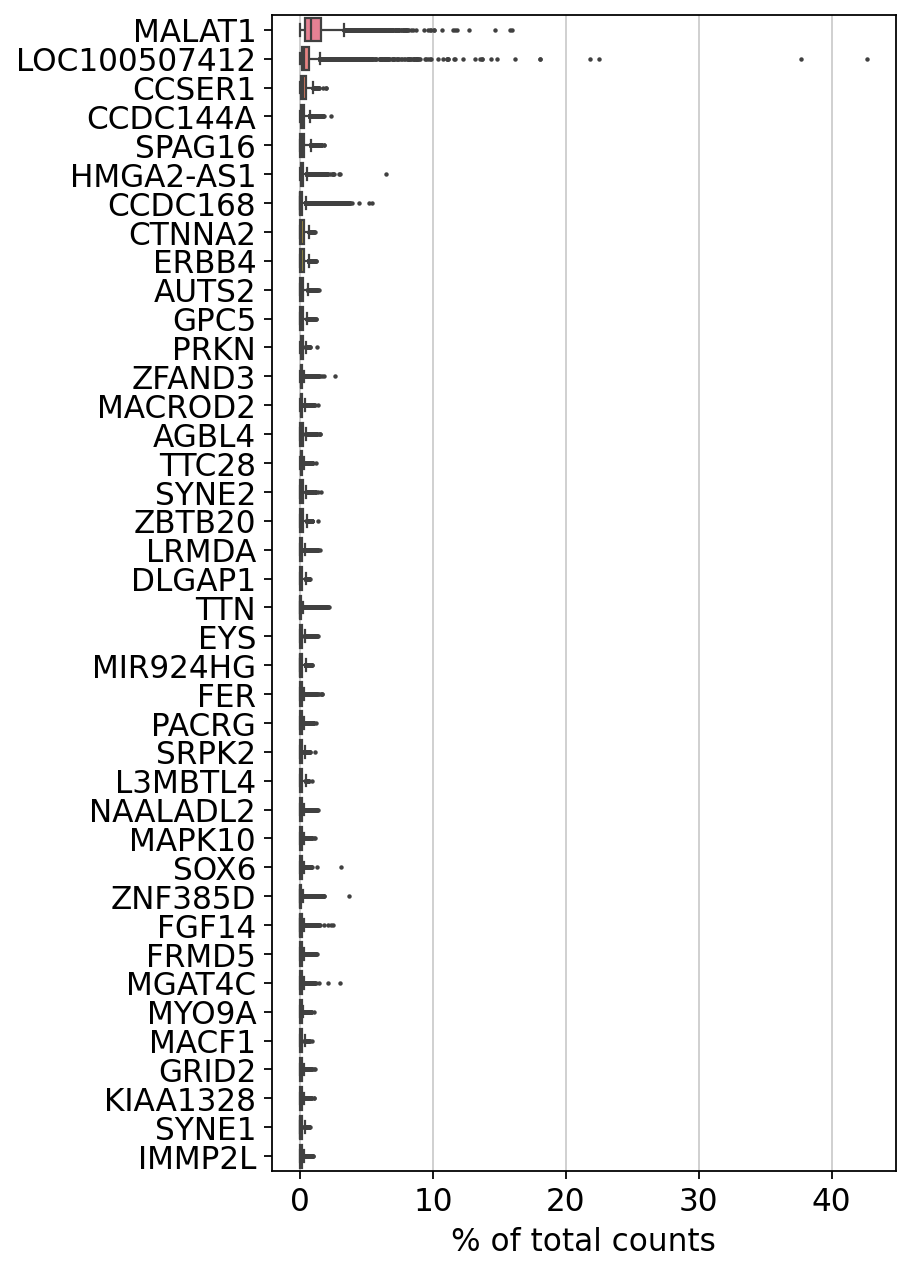

In [40]:
sc.pl.highest_expr_genes(adata_mm, n_top=40, )

# MT DNA

<Axes: xlabel='percent_mito', ylabel='Density'>

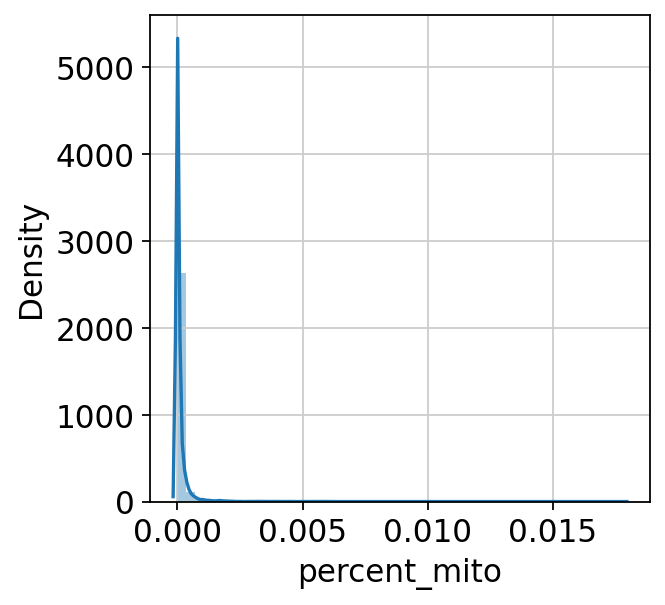

In [41]:
sns.distplot(adata_mm.obs["percent_mito"])

In [42]:
# remove high MT perc
adata_mm = adata_mm[adata_mm.obs["percent_mito"]<0.2].copy()

In [43]:
adata_mm.shape

(11200, 34247)

# Filter on spliced proportion

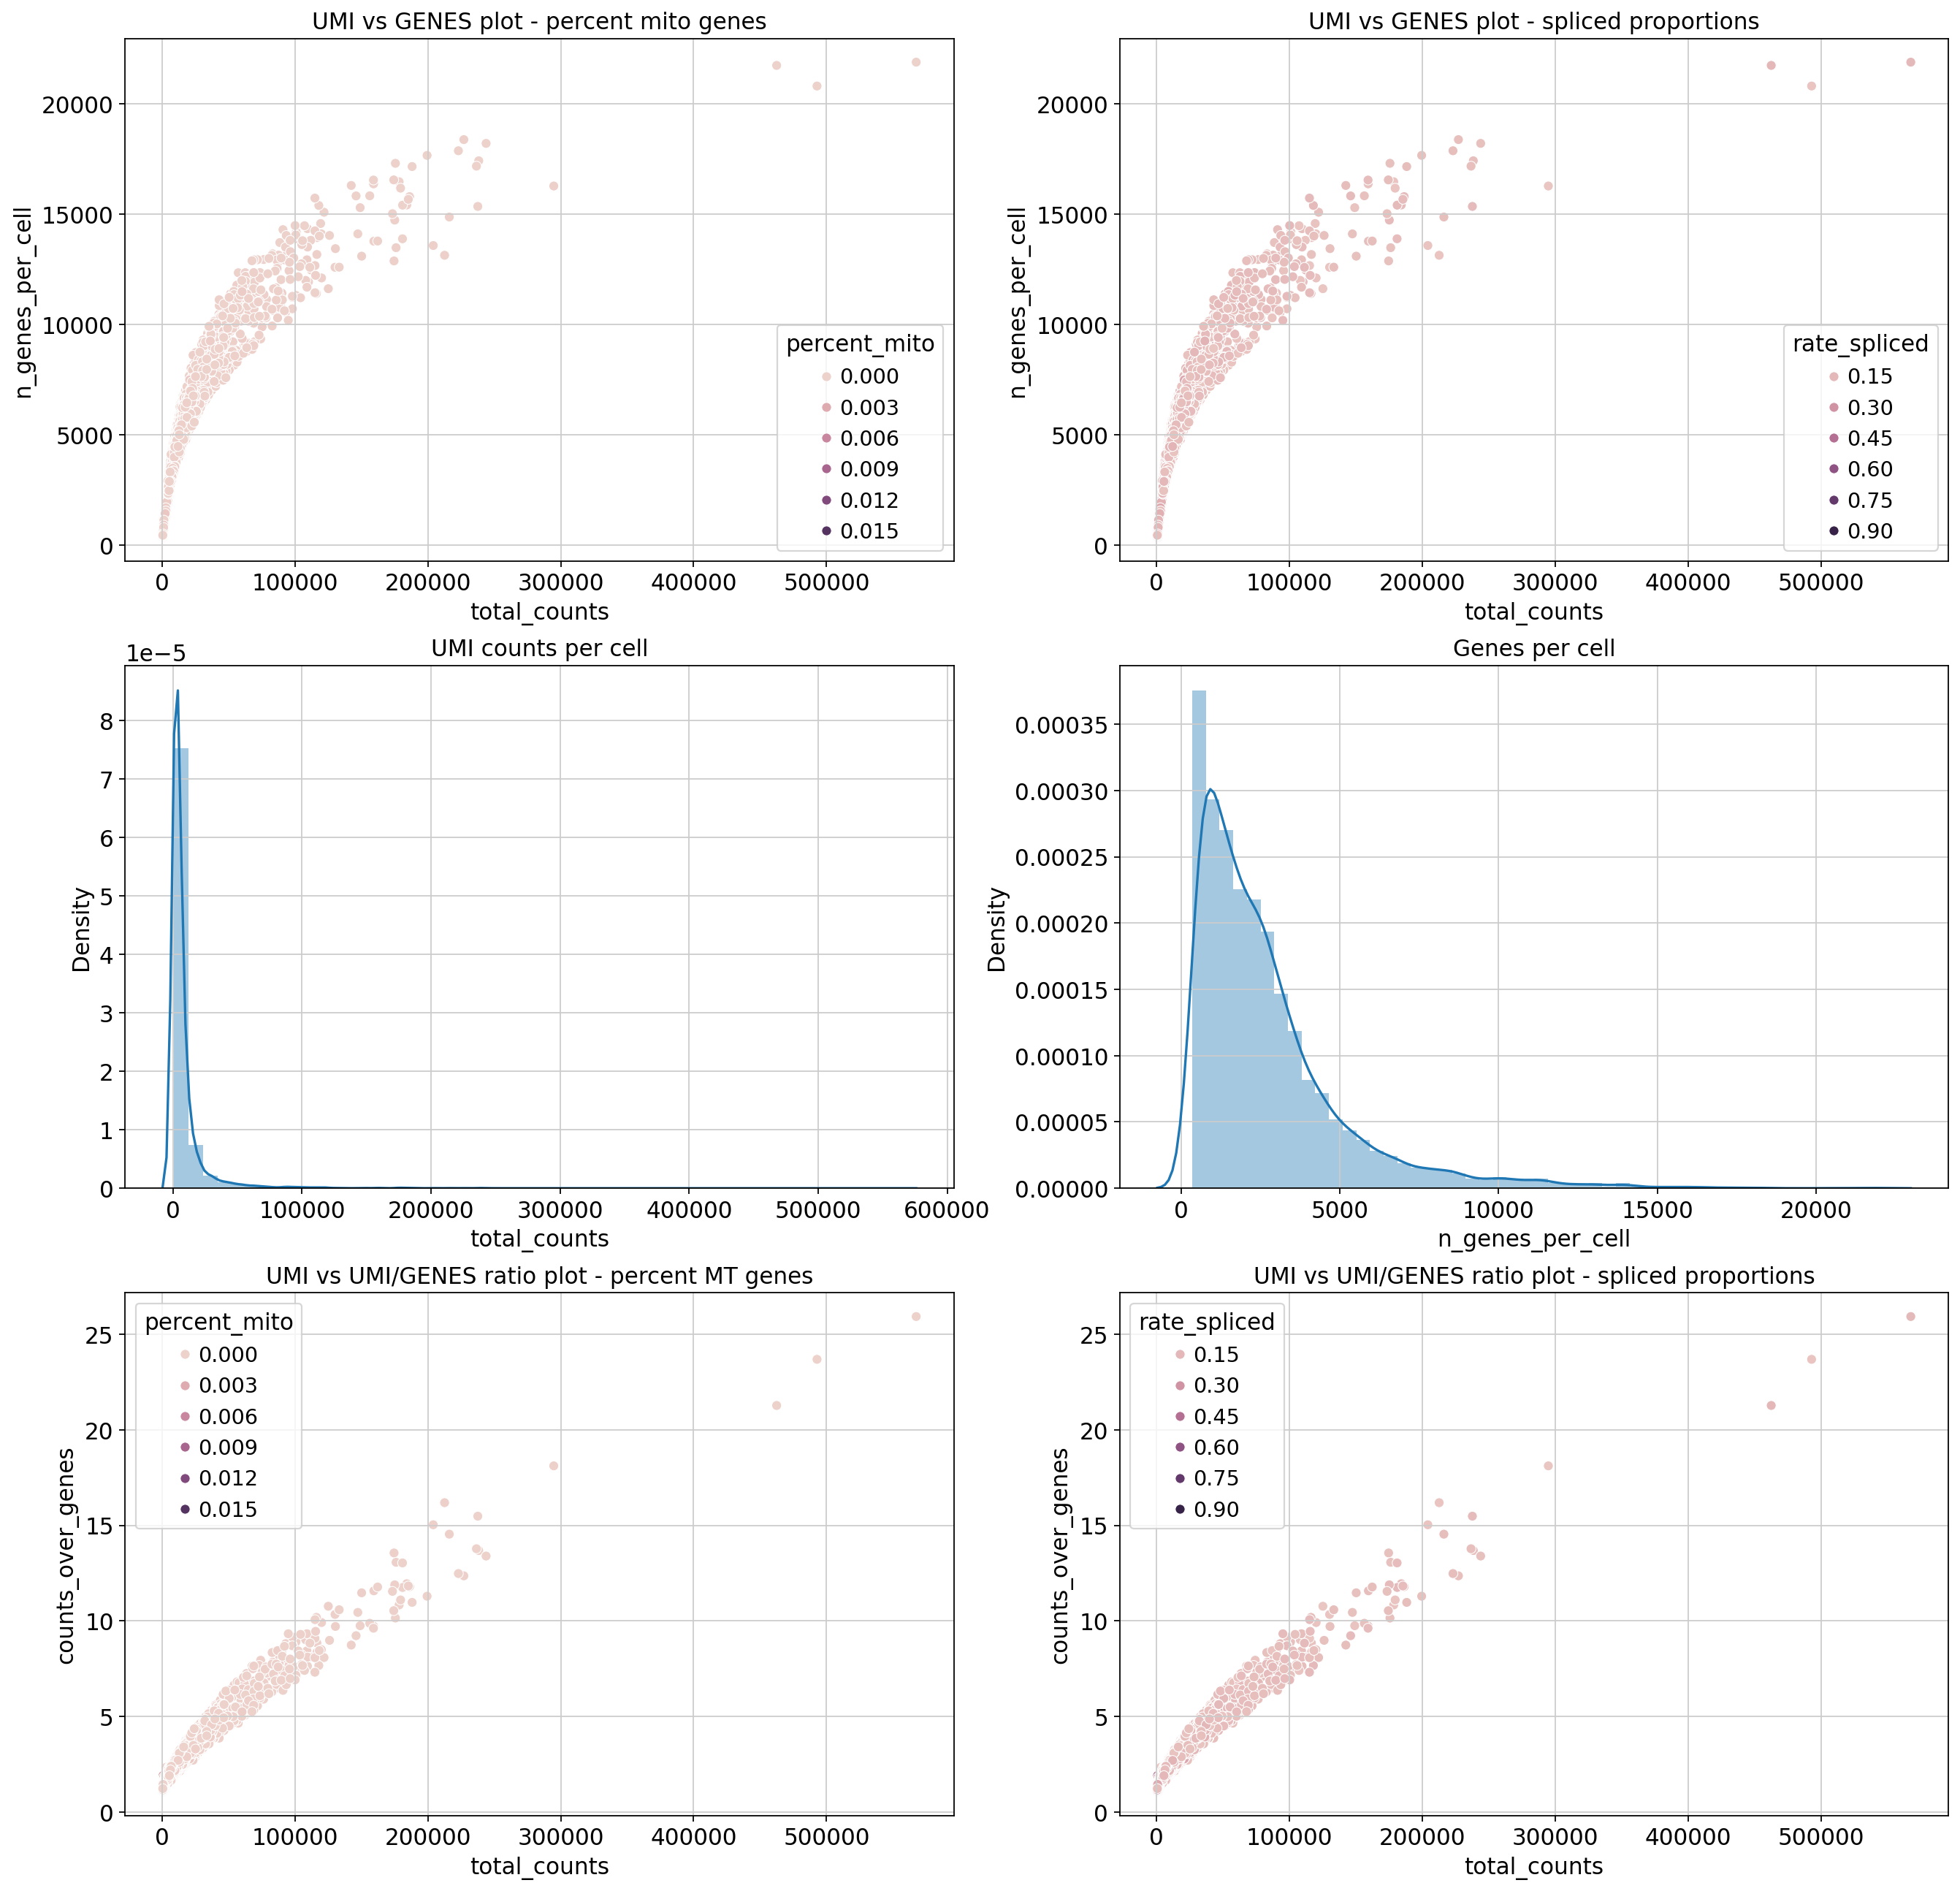

In [44]:
#do some plots of quality measures
plotQC(adata_mm)

In [45]:
#spliced proportions filtering. One can avoid being too rough in filtering, the later filtering based on PCA decomposition is going to help removing remaining outliers with spliced proportions out of range (since those cells also show other abnormal quality measures).
prop_spl = .5
print('Removing',adata_mm[adata_mm.obs['prop_spl']>=prop_spl].shape[0],'cells with equal or more than',prop_spl,'spliced proportion')
adata_mm=adata_mm[adata_mm.obs['prop_spl']<prop_spl].copy()

Removing 94 cells with equal or more than 0.5 spliced proportion


In [46]:
adata_mm.shape

(11106, 34247)

In [47]:
#how it does look like after filtering by spliced proportions
# plotQC(adata_mm)

In [48]:
#Here we can see if there are clls with few observed genes but high spliced proportions. Those are likely remaining outliers. We can remove them now or let the PCA filtering take care of most of them.
# plt.rcParams["figure.figsize"] = (6,6)
# sns.scatterplot(x=adata_mm.obs['n_genes_by_counts'],y=adata_mm.obs['prop_spl'])

# Filter genes

In [49]:
sc.pp.filter_genes(adata_mm, min_cells=50)

filtered out 9480 genes that are detected in less than 50 cells


# Filter doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.08
Detected doublet rate = 27.2%
Estimated detectable doublet fraction = 78.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 34.7%
Elapsed time: 16.7 seconds
Nr of predicted doublets  504
Doublets indices saved in adata.obs["predicted_doublets"]


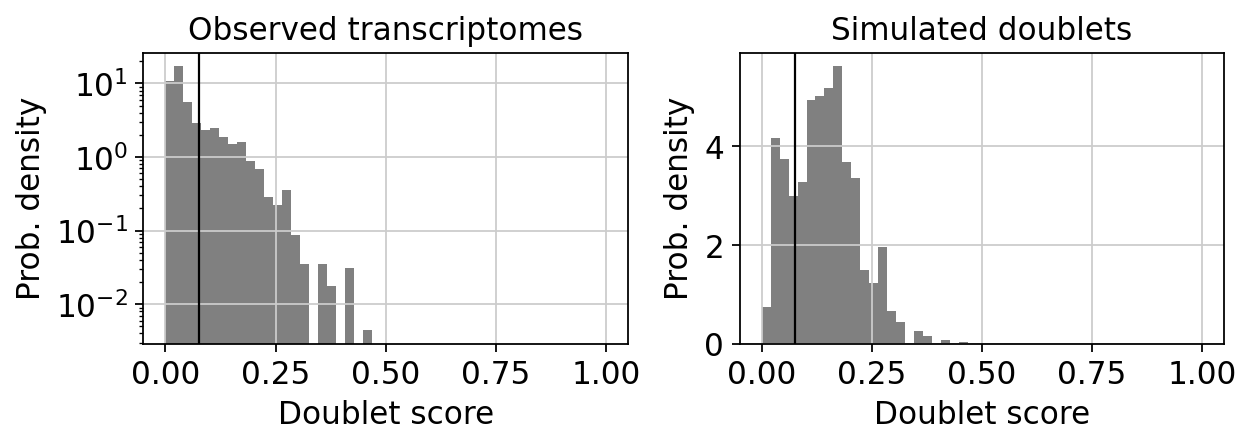

In [50]:
scrublet(adata_mm, expected_rate=0.06, doublet_score=.2)

In [51]:
adata_mm = adata_mm[np.invert(adata_mm.obs['predicted_doublets'])].copy()

# Write output

In [52]:
adata_mm.layers["raw_counts"] = np.array(adata_mm.X.todense())

In [53]:
import os

path_out = f'/home/paulilokiestudia/testis_singlecell/Workspaces/paula/starsolo_v1/{sp}/adata/'

if not os.path.exists(path_out):
    os.makedirs(path_out)

In [54]:
adata_mm

AnnData object with n_obs × n_vars = 10602 × 24767
    obs: 'DATASET', 'batch', 'primer_type', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'doublet_scores', 'predicted_doublets'
    var: 'chromosome', 'n_cells'
    layers: 'spliced', 'unspliced', 'raw_counts'

In [55]:
# adata_mm.write("/home/paulilokiestudia/testis_singlecell/Workspaces/paula/mapping_good/CHMP/adata/andata_1_prenormalization.h5ad")
adata_mm.write(f'{path_out}/preproc_1_starsolo_multimap_QC.h5ad')